In [1]:
%reset -f
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow.keras
import pickle, sys, warnings, os, time, random
import matplotlib.pyplot as plt

sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical


2022-10-14 11:18:10.831802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-10-14 11:18:10.831834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
##############################################################################
# IMPORT DEEP LEARNING PACKAGES
##############################################################################

from sklearn.model_selection import cross_val_score, StratifiedKFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
LeakyReLU = LeakyReLU(alpha=0.1)

from bayes_opt import BayesianOptimization


pd.set_option("display.max_columns", None)


# ENCODING FUNCTIONS
##############################################################################

# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
##############################################################################
# PLOTTING FUNCTIONS 
##############################################################################
def history_plots_(history, SAVE = 0, name = ''):
    auc_keys = [x for x in history.history.keys() if 'auc' in x]
    loss = history.history["loss"];     val_loss = history.history["val_loss"]
    acc  = history.history["accuracy"]; val_acc  = history.history["val_accuracy"]
    auc  = history.history[auc_keys[0]];      val_auc = history.history[auc_keys[1]]
    epochs  = range(1, len(acc) + 1)
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (8,4))
    ax0.plot(epochs, loss, "bo", label="Training Loss")
    ax0.plot(epochs, val_loss, "b", label="Validation Loss")
    ax0.set_title("Train-val Loss")
    ax1.plot(epochs, acc, "bo", label="Training Accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation Accuracy")
    ax1.set_title("Train-val Accuracy")
    ax2.plot(epochs, auc, "bo", label="Training AUC")
    ax2.plot(epochs, val_auc, "b", label="Validation AUC")
    ax2.set_title("Train-val AUC")
    plt.legend()
    if SAVE == 1: plt.savefig(name, transparent = True, bbox_inches = "tight")
    plt.show()
# ============================================================================


In [3]:
t_tot = time.time()
# ##############
# 1. LOAD DATA ---------------------------------------------------------------
# ============================================================================
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
#df_patients_16_18, df_admissions_16_18, _ = load_fn.Load_data()
#df_patients_19_20, df_admissions_19_20, _ = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18_los_1d.pickle','rb'))
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20_los_1d.pickle','rb'))

# List of features ------------------------
feat_list = X_data_16_18[0].columns.tolist()
feat_list = feat_list[1:-1]

# Dictionary of features and types --------
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
data_types = data_types.set_index('Variable').to_dict()['Type']

# Resulst vaiables ------------------------
df_results_train = pd.DataFrame()
df_results_valid = pd.DataFrame()
dict_fpr_tpr = {}

print("Elapsed time loading data:", time.time()-t)
# ============================================================================

# ##############
# 2. PROCESSING DATA ---------------------------------------------------------
# ============================================================================
t = time.time()

### SPLIT DATA #######################################
train_set = X_data_16_18[0].reset_index().copy()
valid_set = X_data_19_20[0].reset_index().copy()

### ENCODING DATA ####################################
train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)

### SET DATA AS ARRAYs ###############################
num_samp_train = len(train_set['admission_id'].unique().tolist())
num_samp_valid = len(valid_set['admission_id'].unique().tolist())
num_features   = len(train_set_norm.columns.tolist())
num_time_samp  = len(train_set[train_set['admission_id']==train_set['admission_id'].tolist()[0]])
X_train_ts = np.array(train_set_norm).reshape((num_samp_train, num_time_samp, num_features ))
X_valid_ts = np.array(valid_set_norm).reshape((num_samp_valid, num_time_samp, num_features ))
df         = train_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()

y_train = list(list(zip(*X_data_16_18[1]))[1])
dict_classes = {'3-4d':0, '5-6d':1, '7d':2, '8-9d':3,'10-13d':4, '2w':5, '3w':6, '4w':7}
los_codes    = lambda x: dict_classes[x] 
y_train_ts      = np.array([los_codes(x) for x in y_train])

y_valid  = list(list(zip(*X_data_19_20[1]))[1])
y_valid_ts  = np.array([los_codes(x) for x in y_valid])

### ONE-HOT ENCODING Y ###############################
y_train_1_ts = to_categorical(y_train_ts, num_classes = 8)
y_valid_1_ts = to_categorical(y_valid_ts, num_classes = 8)

print("Shape of X_train_ts",X_train_ts.shape)
print("Shape of y_train_1_ts",y_train_1_ts.shape)
print("Shape of y_train_ts",y_train_ts.shape)
# ============================================================================

# ##############
# 2. PROCESSING DATA ---------------------------------------------------------
# ============================================================================
t = time.time()

### SPLIT DATA #######################################
train_set = X_data_16_18[0].reset_index().copy()
train_set = train_set[train_set.index % 48 == 0]
valid_set = X_data_19_20[0].reset_index().copy()
valid_set = valid_set[valid_set.index % 48 == 0]

### ENCODING DATA ####################################
train_set_norm, encoder = Normalise_n_encode_train_set(train_set, feat_list, data_types)
valid_set_norm          = Normalise_n_encode_val_set(valid_set, encoder, feat_list, data_types)

### SET DATA AS ARRAYs ###############################
num_samp_train = len(train_set['admission_id'].unique().tolist())
num_samp_valid = len(valid_set['admission_id'].unique().tolist())
num_features   = len(train_set_norm.columns.tolist())
num_time_samp  = len(train_set[train_set['admission_id']==train_set['admission_id'].tolist()[0]])
X_train_sta = np.array(train_set_norm).reshape((num_samp_train, num_time_samp, num_features ))
X_valid_sta = np.array(valid_set_norm).reshape((num_samp_valid, num_time_samp, num_features ))
df          = train_set[['admission_id', 'Mortality']].groupby(by= 'admission_id').mean()

y_train = list(list(zip(*X_data_16_18[1]))[1])
dict_classes = {'3-4d':0, '5-6d':1, '7d':2, '8-9d':3,'10-13d':4, '2w':5, '3w':6, '4w':7}
los_codes    = lambda x: dict_classes[x] 
y_train_sta  = np.array([los_codes(x) for x in y_train])

y_valid  = list(list(zip(*X_data_19_20[1]))[1])
y_valid_sta  = np.array([los_codes(x) for x in y_valid])

### ONE-HOT ENCODING Y ###############################
y_train_1_sta = to_categorical(y_train_sta, num_classes = 8)
y_valid_1_sta = to_categorical(y_valid_sta, num_classes = 8)

print("")
print("Shape of X_train_sta",X_train_sta.shape)
print("Shape of y_train_1_sta",y_train_1_sta.shape)
print("Shape of y_train_sta",y_train_sta.shape)

Elapsed time loading data: 0.2008519172668457
Shape of X_train_ts (7657, 48, 32)
Shape of y_train_1_ts (7657, 8)
Shape of y_train_ts (7657,)

Shape of X_train_sta (7657, 1, 32)
Shape of y_train_1_sta (7657, 8)
Shape of y_train_sta (7657,)


_________________________

_________________________

_________________________

In [4]:
final_df = pd.DataFrame()
lst_fpr_tpr = []

# GRU

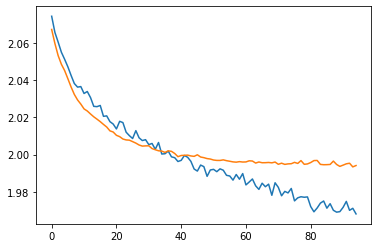

In [5]:
hst_model = pickle.load(open('los_ts_GRU_history.pickle','rb'))[1]
plt.plot(range(len(hst_model['loss'])), hst_model['loss'])
plt.plot(range(len(hst_model['val_loss'])), hst_model['val_loss'])
plt.show()

In [6]:
hst_model.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [7]:
params_nn_ = pickle.load(open('los_ts_GRU_history.pickle','rb'))[0]
layers1       = params_nn_['layers1']; layers2       = params_nn_['layers2']
activation1   = params_nn_['activation1']
activation2   = params_nn_['activation2']
activation3   = params_nn_['activation3']
cellsIni      = params_nn_['cellsIni']
cells1        = params_nn_['cells1']
cells2        = params_nn_['cells2']
cells3        = params_nn_['cells3']
batch_size    = params_nn_['batch_size']
epochs        = params_nn_['epochs']
optimizer_no  = params_nn_['optimizer_no']
dropout_rate1 = params_nn_['dropout_rate1']
dropout_rate2 = params_nn_['dropout_rate2']
dropout1      = params_nn_['dropout1']
dropout2      = params_nn_['dropout2']
learning_rate = params_nn_['learning_rate']

def ft_1dcnn_cl_fun(cellsIni,  cells1, cells2, cells3, activation1, activation2, activation3, 
                    optimizer_no, learning_rate, batch_size, epochs, layers1, layers2, 
                    dropout1, dropout_rate1, dropout2, dropout_rate2):      
    optimizerD = {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                     'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                     'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                     'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    optimizer = list(optimizerD.keys())[optimizer_no]
    nn = Sequential()
    nn.add(layers.GRU(cellsIni, activation=activation1, return_sequences = True, input_shape=(48,32)))
    
    for i in range(layers1):
        nn.add(layers.GRU(cells1, recurrent_activation=activation1, return_sequences = True))
        if dropout1 > 0.5:
            nn.add(layers.SpatialDropout1D(dropout_rate1, seed=123))
    
    for i in range(layers2):
        nn.add(layers.GRU(cells2, recurrent_activation=activation2, return_sequences = True))
        if dropout2 > 0.5:
            nn.add(layers.SpatialDropout1D(dropout_rate2, seed=123))        
    
    nn.add(layers.GRU(cells3, activation=activation3))
    nn.add(layers.Dense(10, activation='relu'))
    nn.add(layers.Dense(8, activation='softmax'))
    nn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return nn
    
t = time.time()
clf_model = ft_1dcnn_cl_fun(cellsIni, cells1, cells2, cells3, activation1, activation2, activation3, 
                    optimizer_no, learning_rate, batch_size, epochs, layers1, layers2, 
                    dropout1, dropout_rate1, dropout2, dropout_rate2)
history = clf_model.fit(X_train_ts, y_train_1_ts, epochs=20, batch_size = batch_size,
                        verbose = 2, validation_split=0.3)

2022-10-14 11:18:15.711473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-10-14 11:18:15.711526: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 11:18:15.711566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spectre11): /proc/driver/nvidia/version does not exist
2022-10-14 11:18:15.711897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

Epoch 1/20
10/10 - 11s - loss: 2.0770 - accuracy: 0.1470 - val_loss: 2.0732 - val_accuracy: 0.1706
Epoch 2/20
10/10 - 2s - loss: 2.0714 - accuracy: 0.1618 - val_loss: 2.0686 - val_accuracy: 0.1706
Epoch 3/20
10/10 - 2s - loss: 2.0664 - accuracy: 0.1685 - val_loss: 2.0642 - val_accuracy: 0.1614
Epoch 4/20
10/10 - 2s - loss: 2.0606 - accuracy: 0.1661 - val_loss: 2.0601 - val_accuracy: 0.1684
Epoch 5/20
10/10 - 2s - loss: 2.0553 - accuracy: 0.1620 - val_loss: 2.0560 - val_accuracy: 0.1628
Epoch 6/20
10/10 - 2s - loss: 2.0507 - accuracy: 0.1623 - val_loss: 2.0522 - val_accuracy: 0.1632
Epoch 7/20
10/10 - 2s - loss: 2.0464 - accuracy: 0.1622 - val_loss: 2.0482 - val_accuracy: 0.1601
Epoch 8/20
10/10 - 2s - loss: 2.0452 - accuracy: 0.1664 - val_loss: 2.0444 - val_accuracy: 0.1623
Epoch 9/20
10/10 - 2s - loss: 2.0427 - accuracy: 0.1704 - val_loss: 2.0411 - val_accuracy: 0.1641
Epoch 10/20
10/10 - 2s - loss: 2.0436 - accuracy: 0.1651 - val_loss: 2.0380 - val_accuracy: 0.1719
Epoch 11/20
10/10 

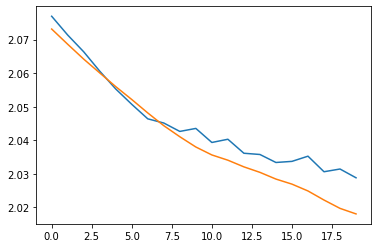

In [8]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.show()

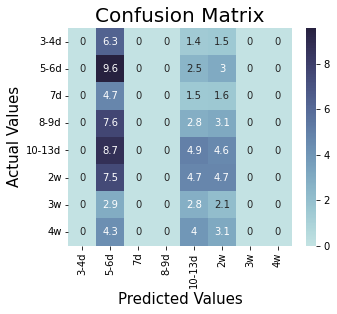

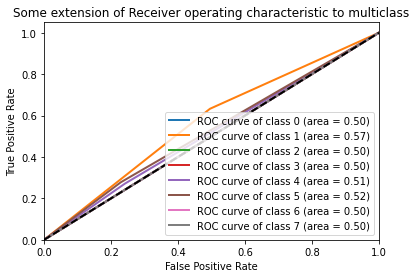

In [9]:
label_classes = dict_classes.keys()
y_test_proba    = clf_model.predict(X_valid_ts)
y_test_predict  = np.argmax(y_test_proba, axis=-1)
LearningCurves.results_precision_recall_cm_multiclass(y_valid_ts, y_test_predict, y_test_proba, label_classes, 
                                                      fig_size = None, save = False, name = None)

In [10]:
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/4_Modelling_TS'

los_stat_SVM_h5_h5.pickle chao


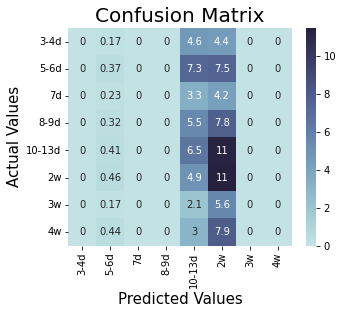

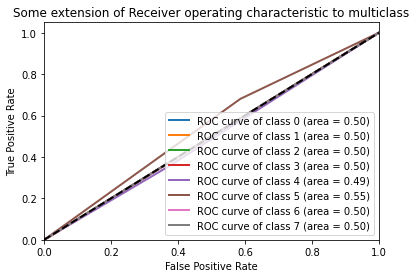

los_ts_LSTM.h5 hola


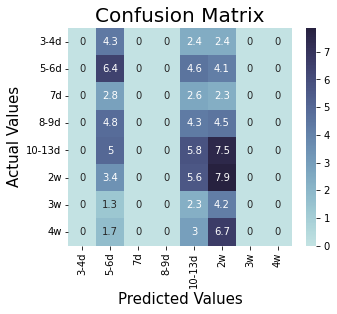

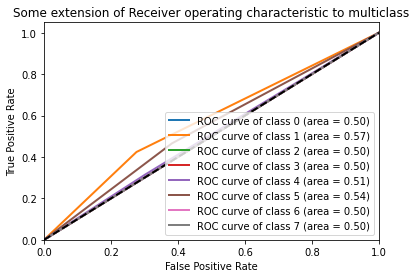

los_stat_GRU.h5 hola_2


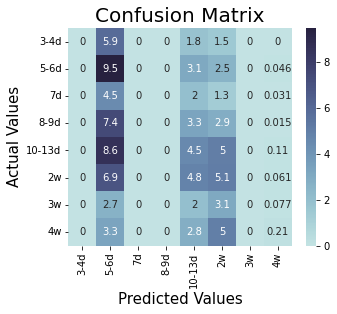

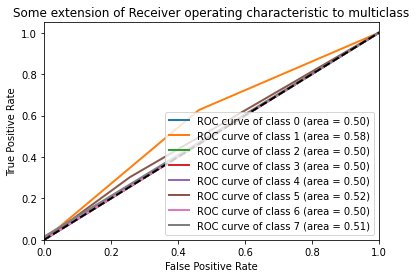

los_stat_XGB_h5.pickle chao


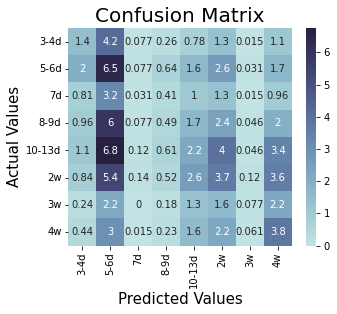

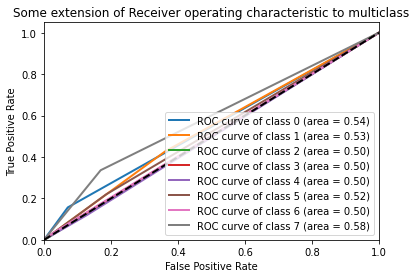

los_stat_LSTM.h5 hola_2


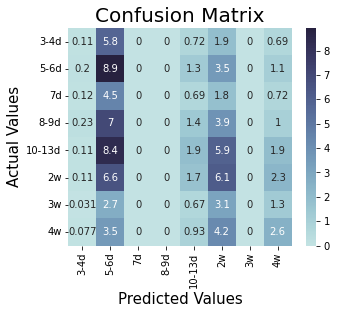

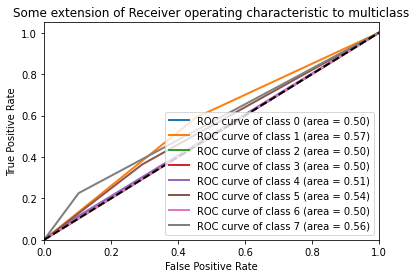

los_ts_GRU.h5 hola


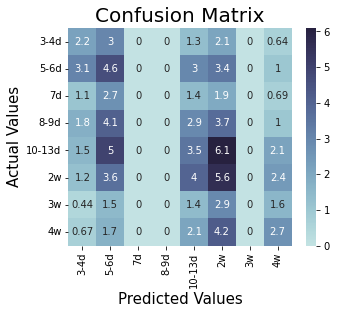

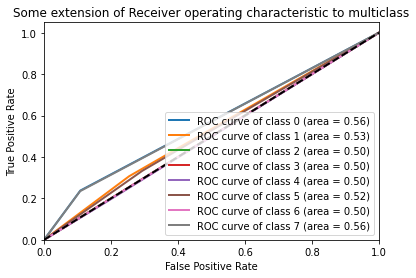

In [11]:
cwd = os.getcwd()
models = [x  for x in os.listdir() if ('h5' in x) ]
m_names = dict(zip(models, [m[:m.find('h5')-1] for m in models]))
for model_name in models:
    if ('.h5' in model_name):
        label_classes = list(dict_classes.keys())
        clf_model = load_model(model_name)
        if ('ts' in model_name):
            print(model_name, 'hola')     
            y_test_proba    = clf_model.predict(X_valid_ts)
            y_test_predict  = np.argmax(y_test_proba, axis=-1)
            LearningCurves.results_precision_recall_cm_multiclass(y_valid_ts, y_test_predict, y_test_proba,label_classes, 
                                                                  fig_size = None, save = True, name = m_names[model_name])
        if ('stat' in model_name):
            print(model_name, 'hola_2')
            y_test_proba    = clf_model.predict(X_valid_sta)
            y_test_predict  = np.argmax(y_test_proba, axis=-1)
            LearningCurves.results_precision_recall_cm_multiclass(y_valid_ts, y_test_predict, y_test_proba,label_classes,
                                                                  fig_size = None, save = True, name = m_names[model_name])
    if '.pickle' in model_name:
        print(model_name, 'chao')
        clf_model = pickle.load(open(model_name,'rb'))[1]
        y_test_proba    = clf_model.predict(X_valid_sta.reshape(len(X_valid_sta),X_valid_sta.shape[-1]))
        y_test_predict  = clf_model.predict(X_valid_sta.reshape(len(X_valid_sta),X_valid_sta.shape[-1]))
        LearningCurves.results_precision_recall_cm_multiclass(y_valid_ts, y_test_predict, y_test_proba,label_classes, 
                                                              fig_size = None, save = True, name = m_names[model_name])


In [12]:
model_name

'los_ts_GRU.h5'